# Initial

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import itertools
from collections import Counter

from combat.pycombat import pycombat

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from time import time

## Code

### Fixing Datasets

In [2]:
def import_csv_files(path, starts_with, ends_with = ".csv"):
    """Imports csv files based on path and starting characters.

    :param path: Path of where to find csv files.
    :param starts_with: Starting characters of dataframes to find.
    :param ends_with: Type of file to load.
    :return: List of loaded csv files.
    """    
    file_list = []
    for filename in os.listdir(path):
        if filename.startswith(starts_with) and filename.endswith(ends_with):
            file_path = os.path.join(path, filename)
            file_list.append(pd.read_csv(file_path))
    return file_list

In [3]:
def same_shape(dfs : list):
    """Checks if all dataframes in a list have the same shape.

    :param dfs: List of dataframes.
    :return: Boolean value if all dataframes have the same shape.
    """    
    return all(df.shape == dfs[0].shape for df in dfs)

In [4]:
def get_average_from_m_datasets(dfs : list):
    """Pools imputed dataset into a single dataframe.

    :param dfs: List of dataframes.
    :return: Singular, pooled dataframe.
    """    
    if not same_shape:
        print("Dataframes must have the same shape")
    joined = pd.concat(dfs).reset_index() 
    return joined.groupby('index').mean()

### Cleaning and Perturbation

In [5]:
def run_combat(df, TMT_set_indices):
    """Run ComBat to reduce batch effect on a dataframe.

    :param df: Dataframe that ComBat is runned on
    :param TMT_set_indices: Labels of which TMT batch each row belongs to.
    :return: DF with ComBat applied to it
    """    
    return pycombat(df.T, TMT_set_indices).T

In [6]:
def add_noise(df, n_samples, std = 0.1):
    """Helper function for simple perturbation function. Adds gaussian noise to randomly sampled rows of the df passed as an argument.

    :param df: df filtered on class
    :param n_samples: Number of samples to perform random sampling on
    :param std: Standard deviation. Defaults to 0.1.
    :return: df with added perturbed samples
    """      
    sampled_df = df.sample(n = n_samples, replace = True)
    gaussian_noise = np.random.normal(0, std, size=sampled_df.shape)
    return sampled_df + gaussian_noise

In [7]:
def simple_perturbation(X, y, n_samples_per_class = None, std = 0.1):
    """Performs a simple perturbation by sampling random rows of classes and adds gaussian noise to them

    :param X: Dataframe with samples to get perturbed
    :param y: Class labels
    :param n_samples_per_class: Decides how many samples per class that are going to be sampled, defaults to None. 
    If none -> all classes will get equal weight according to size of current largest class.
    :param std: How much the noise can deviate from the mean (Standard dev.), defaults to 0.1
    :return: A df with the perturbed samples. A list stating which row belongs to which class.
    """    
    classes = y.value_counts()
    if n_samples_per_class is None:
        largest_class = classes.argmax()
        largest_n_samples = classes.pop(largest_class)
    else:
        largest_n_samples = n_samples_per_class
    df_list = []
    y_new_classes = list(y)
    for idx, n_samples in classes.items():
        perturbed = add_noise(X[y == idx], largest_n_samples - n_samples, std=std)
        df_list.append(perturbed)
        y_new_classes = y_new_classes + [idx] * len(perturbed)
    return pd.concat([X] + df_list, axis=0), y_new_classes

### GridSearch and Feature Importance

In [8]:
def get_best_params(X, y, models, params, cv = 5, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.

    :return: DF with ComBat applied to it
    """   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"{model.name} started.")
        clf = GridSearchCV(model, param_grid=param, cv=cv, n_jobs=n_jobs, scoring="f1_weighted")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [ ]:
def get_average_feature_importance_old(d, model_name, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.


    :param d: Dictionary with results.
    :param model_name: Name of the models.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    avg_feature_importance = {}
    keys = [key for key in d.keys() if key.startswith(f'{model_name}')]
    for key in keys:
        model = d[key]
        importances = model.feature_importances_
        for index, importance in enumerate(importances):
            name = df.columns[index]
            if name in avg_feature_importance:
                avg_feature_importance[name] += importance
            else:
                avg_feature_importance[name] = importance
    for feature, total in avg_feature_importance.items():
        mean = total / len(keys)
        avg_feature_importance[feature] = mean
    
    return avg_feature_importance

In [65]:
def get_average_feature_importance_XGB_RF(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    avg_feature_importance = {}
    for model in models:
        importances = model.feature_importances_
        for index, importance in enumerate(importances):
            name = df.columns[index]
            if name in avg_feature_importance:
                avg_feature_importance[name] += importance
            else:
                avg_feature_importance[name] = importance
    for feature, total in avg_feature_importance.items():
        mean = total / len(models)
        avg_feature_importance[feature] = mean
    
    return avg_feature_importance

In [66]:
def get_average_feature_importance_LR(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    all_coefficients = []
    feature_names = df.columns.tolist()
    
    for model in models:
        coefficients = model.coef_[0]
        abs_coefficients = np.abs(coefficients)
        all_coefficients.append(abs_coefficients)
    
    avg_coefficients = np.mean(all_coefficients, axis=0)
    normalized_coefficients = avg_coefficients / np.sum(avg_coefficients)
    feature_importance = dict(zip(feature_names, normalized_coefficients))
    
    return feature_importance

In [67]:
def get_average_feature_importance(d, model_name, df):
    """Wrapper function in order to extract average feature importance across multiple iterations of multiple models.

    :param d: Dictionary with models.
    :param model_name: Name of the model.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    models = [model for key, model in d.items() if key.startswith(f'{model_name}')]
    if model_name == "LR":
        return get_average_feature_importance_LR(models, df)
    return get_average_feature_importance_XGB_RF(models, df)

### Voting

In [10]:
def hard_voting(models):
    """Hard voting based on predictions from multiple models.

    :param models: List of trained models.
    :return: Hard voting results.
    """  
    predictions = [model.prediction for model in models]
    predictions = [[row[i] for row in predictions] for i in range(len(predictions[0]))]
    results = []
    for index, p in enumerate(predictions):
        most_common = Counter(p).most_common()
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            probabilities = [model.probability[index] for model in models]
            probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
            probabilities = [sum(sublist) for sublist in probabilities]
            if len(most_common) > 2 and most_common[0][1] == most_common[2][1]:
                results.append(np.argmax(probabilities))
            else:
                probabilities[most_common[2][0]] = 0
                results.append(np.argmax(probabilities))
        else:
            results.append(most_common[0][0])

    return results  

In [11]:
def summed_votes(pred_proba):
    """Summs the soft vote prediction probability together.

    :param pred_proba: The prediciton probability from the different models.
    :return: The summized prediction probability.
    """  
    length = len(pred_proba[0])
    summed_columns = []

    for i in range(length):
        column_sum = np.sum([preds[i] for preds in pred_proba], axis=0)
        summed_columns.append(column_sum)

    return summed_columns

In [12]:
def soft_voting(models):
    """Soft voting based on predictions from multiple models.

    :param models: List of trained models.
    :return: Soft voting results.
    """  
    probabilities = [model.probability for model in models]
    probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
    results = []
    for p in probabilities:
        vote = summed_votes(p)
        results.append(np.argmax(vote))
    return results

### Main Pipeline

In [13]:
def pipeline(X, y, models, params, tmt_set = None, K = 5, n_samples_per_class = 100):
    """Main pipeline code that runs K-fold validation.

    :param X: Dataframe of X values for training.
    :param y: Pandas series of real class values for training 
    :param models: Models to be trained on X and y.
    :param params: Parameter settings to get best parameters from.
    :param tmt_set: Pandas series with indexes for batches from TMT sets.
    :param K: Number of K-fold iterations to run.
    :param n_samples_per_class: Number of samples per class that should exist after perturbation.
    :return: -
    """  
    X = run_combat(X, tmt_set)
    k_fold = StratifiedKFold(n_splits=K, shuffle=True)
    for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        X_train, y_train = simple_perturbation(X_train, y_train, n_samples_per_class=n_samples_per_class)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        best_params = get_best_params(X_train, y_train, models, params)
        for model in models:
            best_model = model.__class__(**best_params[model.name])
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            print(f1_score(y_test, y_pred, average="weighted"))

In [14]:
def create_models(iteration):
    """Creates 3 new basemodels with names depending on iteration.

    :param iteration: Current iteration in K-Fold cross validation.
    :return: List of base models.
    """      
    xgboost = XGBClassifier()
    xgboost.name = f"XGB {iteration}"
    lr = LogisticRegression()
    lr.name = f"LR {iteration}"
    rf = RandomForestClassifier()
    rf.name = f"RF {iteration}"

    return [xgboost, lr, rf]

In [15]:
def pipeline_2(X, y, params, tmt_set = None, K = 5, n_samples_per_class = 100):
    """Main pipeline code that runs K-fold validation.

    :param X: Dataframe of X values for training.
    :param y: Pandas series of real class values for training 
    :param params: Parameter settings to get best parameters from.
    :param tmt_set: Pandas series with indexes for batches from TMT sets.
    :param K: Number of K-fold iterations to run.
    :param n_samples_per_class: Number of samples per class that should exist after perturbation.
    :return: -
    """  
    all_models = {}
    votes = {}
    y_true = {}
    X = run_combat(X, tmt_set)
    k_fold = StratifiedKFold(n_splits=K, shuffle=True)
    print("\n-------------- Starting K-fold cross validation: --------------\n")
    for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        print(f"K-Fold validation: Iteration {i}.")
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        X_train, y_train = simple_perturbation(X_train, y_train, n_samples_per_class=n_samples_per_class)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        models = create_models(i)
        best_params = get_best_params(X_train, y_train, models, params)
        y_true[f'{i}'] = y_test
        best_models = []
        for model in models:
            best_model = model.__class__(**best_params[model.name])
            best_model.name = model.name
            best_model.fit(X_train, y_train)
            best_model.prediction = best_model.predict(X_test)
            best_model.probability = best_model.predict_proba(X_test)
            all_models[best_model.name] = best_model
            best_models.append(best_model)
        hard = f'Hard vote {i}'
        soft = f'Soft vote {i}'
        votes[hard] = hard_voting(best_models)
        votes[soft] = soft_voting(best_models)
        print(f'Hard vote f1 score: {f1_score(y_test, votes[hard], average="weighted")}')
        print(f'Soft vote f1 score: {f1_score(y_test, votes[soft], average="weighted")}\n')
    
    return all_models, votes, y_true

### Plotting Code

In [33]:
def plot_confusion_matrix(ax, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.

    :param ax: Axis to print confusion matrix on.
    :param cm: Pre-made sklearn confusion matrix.
    :param classes: Values of predicted classes.
    :param normalize: If True, normalizes the values between 0 and 1.
    :param title: Title of confusion matrix.
    :param cmap: Colour of confusion matrix.
    """ 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [34]:
def plot_soft_vote_confusion_matrix(y_real, y_pred, title="Confusion Matrix"):
    """Wrapper function for plot_confusion_matrix.

    :param y_real: The real y class.
    :param y_pred: The predicted y class.
    """      
    cnf_matrix = confusion_matrix(y_real, y_pred)
    np.set_printoptions(precision=2)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    plot_confusion_matrix(axs[0], cnf_matrix, classes=['CN', 'MCI', 'AD'],
                          title=f'{title}, no normalization')

    plot_confusion_matrix(axs[1], cnf_matrix, classes=['CN', 'MCI', 'AD'], normalize=True,
                          title=f'{title}, normalized')

    plt.show()

In [18]:
def plot_percentiles(percentiles, labels, title="Accuracy scores"):
    """
    Plot percentiles against labels.

    :param percentiles: List of percentiles.
    :param labels: List of strings (labels).
    """
    x = range(len(labels))
    
    plt.figure(figsize=(8, 6))
    plt.bar(x, percentiles, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(x, labels)
    plt.ylim(0, 1)
    plt.show()

In [104]:
def plot_feature_importance(dict1, dict2, dict3, models=["Model1", "Model2", "Model3"], main_model = None, colours = ["b", "g", "r"]):
    sorted_dict1 = dict(sorted(dict1.items(), key=lambda item: item[1], reverse=True))
    top_features_dict1 = list(sorted_dict1.items())[:20]
    top_features_keys = [key for key, _ in top_features_dict1]

    feature_importance_dict1 = [val for _, val in top_features_dict1]
    feature_importance_dict2 = [dict2[key] for key in top_features_keys]
    feature_importance_dict3 = [dict3[key] for key in top_features_keys]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar([i - 0.2 for i in range(20)], feature_importance_dict1, width=0.2, color=colours[0], label=models[0])
    ax.bar([i for i in range(20)], feature_importance_dict2, width=0.2, color=colours[1], label=models[1])
    ax.bar([i + 0.2 for i in range(20)], feature_importance_dict3, width=0.2, color=colours[2], label=models[2])

    ax.set_xticks(range(20))
    ax.set_xticklabels(top_features_keys, rotation=90)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title(f"Top 20 feature from {main_model}")
    ax.legend()

    plt.tight_layout()
    plt.show()

# TEST

## Pipeline

In [19]:
#Loading dataframes, Pooling and classes.
path = "./Data/data files/imputed"
starts_with = "protein_lumbar"
dfs = import_csv_files(path=path, starts_with=starts_with)
df_main = get_average_from_m_datasets(dfs)

df_classes = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv", usecols=["Cortical_biopsy_grouping", "CSF_type", "TMT Set"])
df_classes = df_classes[df_classes["CSF_type"] == "L"].reset_index(drop=True)
tmt_set = df_classes["TMT Set"]
y = df_classes["Cortical_biopsy_grouping"]

In [20]:
#Models
xgboost = XGBClassifier()
xgboost.name = "XGB"
lr = LogisticRegression()
lr.name = "LR"
rf = RandomForestClassifier()
rf.name = "RF"

models = [xgboost, lr, rf]

In [21]:
#QUICK FOR TESTING
xgboost_params = {"min_child_weight": [1],
                  "gamma": [2],
                  "subsample": [0.8],
                  "colsample_bytree": [1.0],
                  "max_depth": [3],
                  "n_estimators": [50, 100]}
lr_params = [{"penalty": ["l1"],
              "C": [1],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [1000, 2000]
             }]
rf_params = {"n_estimators": [100, 300],
             "criterion": ["gini"],
             "max_depth": [ 20],
             "max_features": ["sqrt"],
             "min_samples_leaf": [2]}

params_1 = [xgboost_params, lr_params, rf_params]

In [22]:
#Parameters for GridSearchCV
xgboost_params = {"learnings_rate": {0.01, 0.05, 0.1, 0.2},
                  "min_child_weight": [1, 5, 10],
                  "gamma": [0, 0.2, 0.5, 1, 2],
                  "subsample": [0.6, 0.8, 1.0],
                  "colsample_bytree": [0.6, 0.8, 1.0],
                  "max_depth": [3, 4, 5],
                  "n_estimators": [100, 300, 500],}
lr_params = [{"penalty": ["l1"],
              "C": np.arange(0.2, 2.1, 0.2),
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": np.arange(1000, 10001, 2000)
             }]
rf_params = {"n_estimators": np.arange(100, 501, 100),
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [None, 10, 20, 40],
             "max_features": ["sqrt", "log2"],
             "min_samples_leaf": [1, 2, 4]}

params_2 = [xgboost_params, lr_params, rf_params]

In [23]:
#(Faster) Parameters for GridSearchCV
xgboost_params = {"min_child_weight": [1, 5],
                  "gamma": [0.2, 0.5, 1],
                  "subsample": [1.0],
                  "colsample_bytree": [1.0],
                  "max_depth": [3, 4],
                  "n_estimators": [100, 500]}
lr_params = [{"penalty": ["l1"],
              "C": [0.01, 0.1, 1, 10],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": np.arange(4000, 8001, 2000),
              "tol": [1e-3, 1e-4, 1e-5]
             }]
rf_params = {"n_estimators": [100, 300, 500],
             "criterion": ["gini", "log_loss"],
             "max_depth": [None, 10, 20, 40],
             "max_features": ["sqrt", "log2"],
             "min_samples_leaf": [1, 2, 4]}

params_3 = [xgboost_params, lr_params, rf_params]

In [24]:
#pipeline(df_main, y, models, params, tmt_set)
all_models, votes, y_true = pipeline_2(df_main, y, params_3, tmt_set)

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data

-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


[10:54:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

XGB 0 is done in 104.97201824188232 seconds.

LR 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 0 is done in 176.82186555862427 seconds.

RF 0 started.
RF 0 is done in 21.797213554382324 seconds.

[10:57:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote f1 score: 0.44152249134948096
Soft vote f1 score: 0.2679738562091503

K-Fold validation: Iteration 1.
XGB 1 started.
[11:00:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

XGB 1 is done in 106.10178017616272 seconds.

LR 1 started.
LR 1 is done in 136.9987633228302 seconds.

RF 1 started.
RF 1 is done in 21.52785587310791 seconds.

[11:03:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

Hard vote f1 score: 0.47635524798154555
Soft vote f1 score: 0.4725490196078431

K-Fold validation: Iteration 2.
XGB 2 started.
[11:04:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

XGB 2 is done in 99.42891645431519 seconds.

LR 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 2 is done in 151.30522751808167 seconds.

RF 2 started.
RF 2 is done in 21.52414321899414 seconds.

[11:07:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote f1 score: 0.330795847750865
Soft vote f1 score: 0.330795847750865

K-Fold validation: Iteration 3.
XGB 3 started.
[11:09:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

XGB 3 is done in 101.95497298240662 seconds.

LR 3 started.
LR 3 is done in 146.29516506195068 seconds.

RF 3 started.
RF 3 is done in 22.218302726745605 seconds.

[11:12:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

Hard vote f1 score: 0.37437485115503694
Soft vote f1 score: 0.37437485115503694

K-Fold validation: Iteration 4.
XGB 4 started.
[11:14:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learnings_rate" } are not used.

XGB 4 is done in 104.29462742805481 seconds.

LR 4 started.
LR 4 is done in 138.09462332725525 seconds.

RF 4 started.
RF 4 is done in 21.17

## Results

In [29]:
#Combining K-fold results.
hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

### Confusion Matrix (Average across all runs)

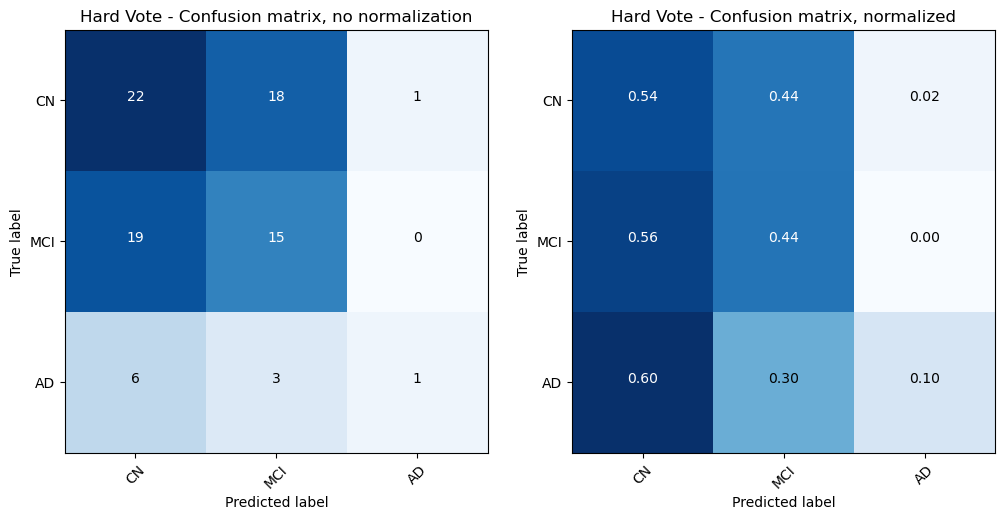

In [35]:
#Confusion Matrix (HARD VOTE).
y_true_class = y_trues
y_pred_class = hard_votes

plot_soft_vote_confusion_matrix(y_true_class, y_pred_class, title="Hard Vote - Confusion matrix")

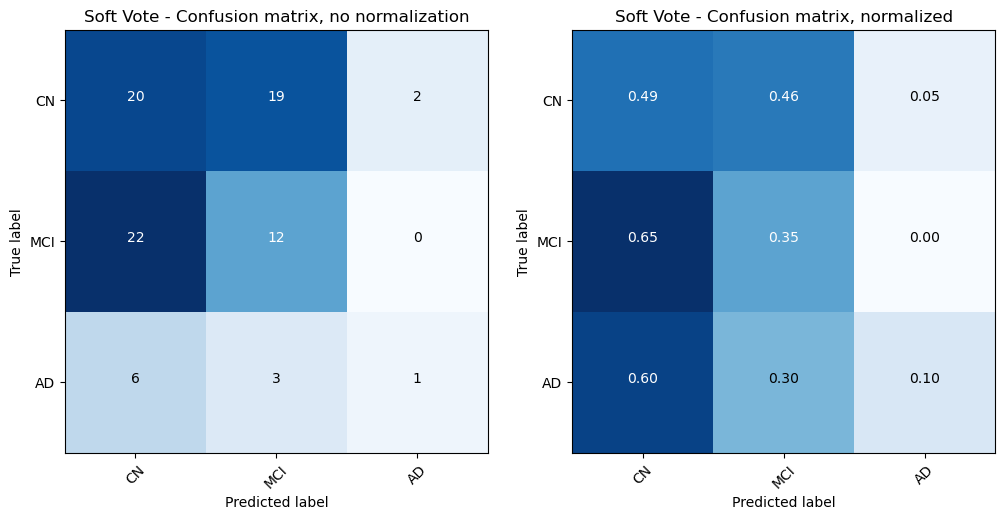

In [36]:
#Confusion Matrix (SOFT VOTE).
y_true_class = y_trues
y_pred_class = soft_votes

plot_soft_vote_confusion_matrix(y_true_class, y_pred_class, title="Soft Vote - Confusion matrix")

### Accuracy (Average across all runs)

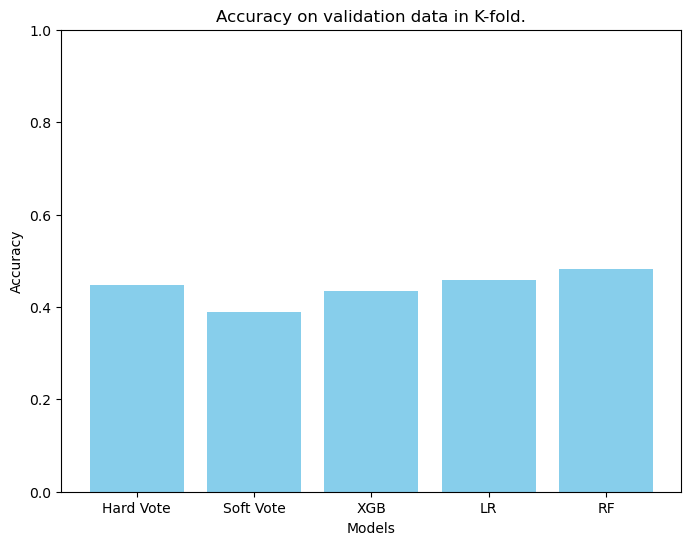

In [32]:
# Example usage:
percentiles = [accuracy_score(y_trues, hard_votes),
                accuracy_score(y_trues, soft_votes),
                accuracy_score(y_trues, xgb_votes),
                accuracy_score(y_trues, lr_votes),
                accuracy_score(y_trues, rf_votes)]
labels = ["Hard Vote", "Soft Vote", "XGB", "LR", "RF"]
plot_percentiles(percentiles, labels, "Accuracy on validation data in K-fold.")

### Feature Importance (Average across all runs)

In [73]:
RF_avg_feature_importance = get_average_feature_importance(all_models, "RF", df_main)
XGB_avg_feature_importance = get_average_feature_importance(all_models, "XGB", df_main)
LR_avg_feature_importance = get_average_feature_importance(all_models, "LR", df_main)

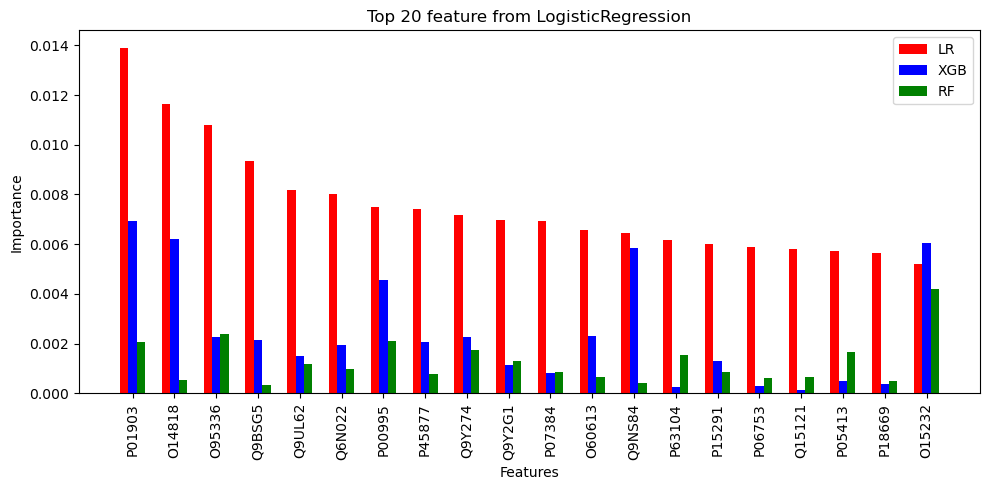

In [101]:
plot_feature_importance(LR_avg_feature_importance, XGB_avg_feature_importance, RF_avg_feature_importance, models=["LR", "XGB", "RF"], main_model="LogisticRegression", colours = ["r", "b", "g"])

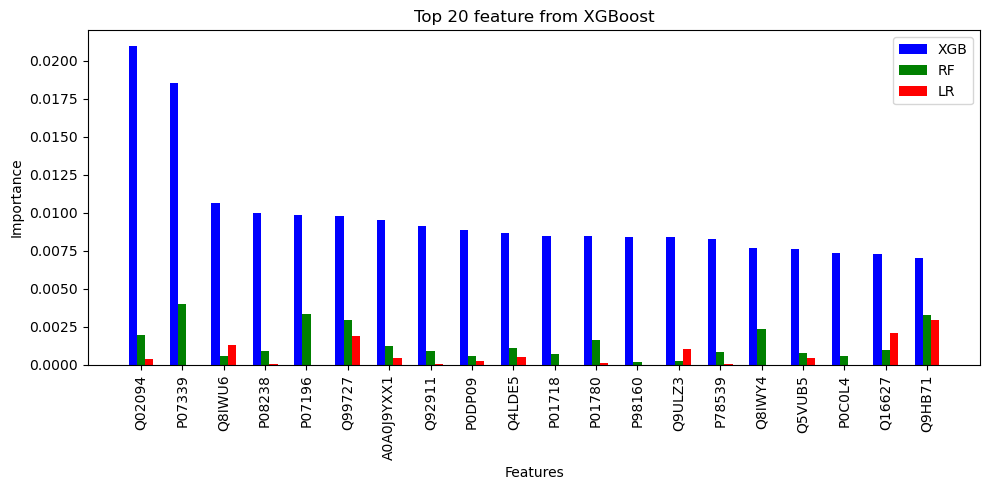

In [102]:
plot_feature_importance(XGB_avg_feature_importance, RF_avg_feature_importance, LR_avg_feature_importance, models=["XGB", "RF", "LR"], main_model="XGBoost", colours = ["b", "g", "r"])

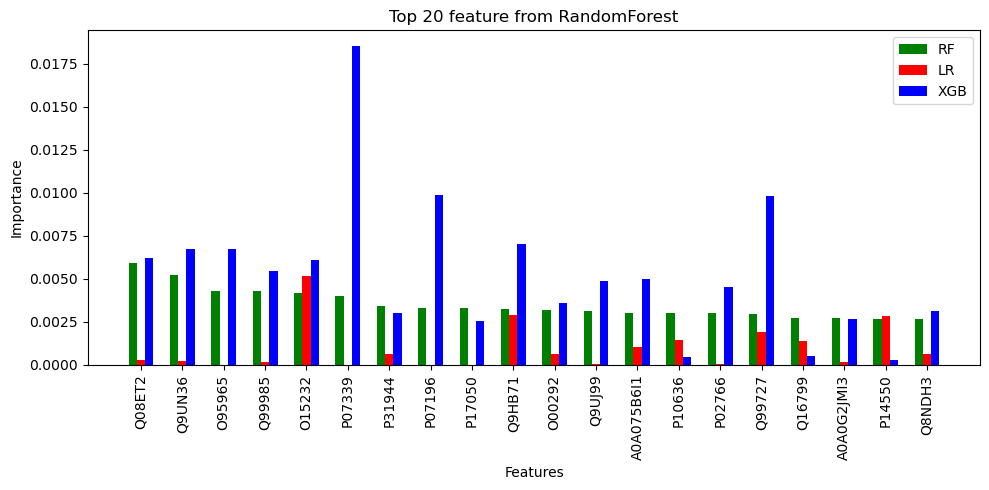

In [103]:
plot_feature_importance(RF_avg_feature_importance, LR_avg_feature_importance, XGB_avg_feature_importance, models=["RF", "LR", "XGB"], main_model="RandomForest", colours = ["g", "r", "b"])